# Backtest a  Strategy

In [1]:
%matplotlib inline
from src.domain.services.stats import return_series
# extend pandas functionality with metrics, etc.
from src.application.services.historical_downloader_handler import historical_downloader
import datetime as dt
import pandas as pd
from src.infrastructure.database_handler import read_data_to_dataframe
from src.application.services.portfolio_constructor import Portfolio_Constructor
from src.application import conf

CCXT Version: 2.0.25


/opt/anaconda3/envs/SmartBots/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Parameters

In [2]:
asset_type = 'crypto' # financial , crypto
fresh_start = False # if you want to download the symbols again
download_data = False # True for downloading
start_date = dt.datetime(2022,1,1) # Start date of data to download
end_date = dt.datetime.utcnow() # End date of data to download
# Portfolio construction
inicial_cash = 50000 # initial capital for the portfolio
base_currency = 'USD'
if asset_type == 'crypto':
    interval = '1h'  # 1m , 5m, 30m, 1h
    provider = 'kucoin'  # test , binance, coinbase ...
    symbols = ["BTC-USDT","ETH-USDT"] # List of symbols to download from provider
    benchmark = "BTC-USDT"
elif asset_type == 'financial':
    interval = '1m'  # 1min , 5min, 30mi
    provider = 'darwinex'  #
    symbols = ["AUDNZD","EURJPY"] # List of symbols to download from provider
    benchmark = "SPY"




## 1) Download Historical Data from Data Provider and save into the database.
Please see here the docs for crypto of the exchanges available: https://github.com/ccxt/ccxt/wiki/Manual#markets


If you already have the data in a database, you can skip this step and go to the next.

Dependings of the symbols and the length of the data, the data loader will take some time to complete. Be pacience.

If there are already some data in the database, it will update only the new data.


In [3]:
if download_data:
    clean_symbols_database = []
    if fresh_start:
        clean_symbols_database = symbols
     # Interval of data to download,
    historical_downloader(symbols=symbols,start_date=start_date, end_date=dt.datetime.utcnow(),
                          provider=provider,clean_symbols_database=clean_symbols_database,interval=interval)

## 2) Read Historical Data from Database and Visualize it.


In [5]:
mongo_host = conf.MONGO_HOST
mongo_port = conf.MONGO_PORT
df1 = read_data_to_dataframe(symbols[0], provider,start_date=start_date,end_date=end_date, interval=interval, mongo_host=mongo_host,
                            mongo_port=mongo_port)
df2 = read_data_to_dataframe(symbols[-1], provider,start_date=start_date,end_date=end_date,interval=interval, mongo_host=mongo_host,
                             mongo_port=mongo_port)

df = pd.concat([df1,df2],axis=0)

<AxesSubplot:xlabel='date'>

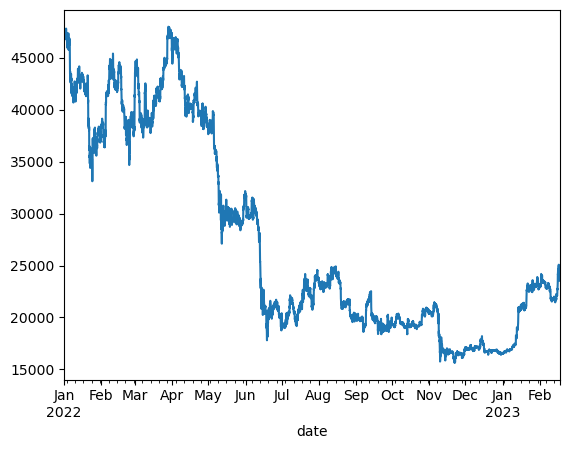

In [6]:
df1.close.plot()

## 3) BackTesting

### Settings of the strategy

In [10]:


strategy1 = {'id': 1, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'AUDNZD',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0, 'base_currency':{'ticker':base_currency+'NZD','value':1.7}}}

strategy2 = {'id': 2, # unique id for strategy to run
             'strategy': 'Simple_Avg_Cross', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'EURJPY',
             'short_period': 10,
             'long_period': 500,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0, 'base_currency':{'ticker':base_currency+'JPY','value':145}}}

strategy3 = {'id': 3, # unique id for strategy to run
             'strategy': 'RSI_Chatgpt', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'EURJPY',
             'period': 14,
             'quantity': 1,
             'limit_save_values':1000,'point_value':100000,'slippage':0, 'base_currency':{'ticker':base_currency+'JPY','value':145}}}

strategy4 = {'id': 4, # unique id for strategy to run
             'strategy': 'TrendFollowing_ChatGpt', # strategy name, create in smartbots/crypto/strategies
             'params': {'ticker': 'BTC-USDT',
             'pattern_length': 3,
             'short_ma_period': 50,
             'long_ma_period': 200,
             'quantity': 1,
             'limit_save_values':1000,'point_value':1,'slippage':0}}

conf_portfolio = {'Name': 'PortfolioExample1',
                  'Data_Sources': 
                  [{'tickers': symbols,
                   'event_type': 'bar',
                   'historical_source': 'mongoDB',
                   'historical_library': f'{provider}_historical_{interval}'}],
                   'Strategies': 
                    [strategy4]}

In [11]:
# baskteting the strategies
portfolio = Portfolio_Constructor(conf_portfolio, run_real=False, asset_type=asset_type,
                                  send_orders_to_broker=False, start_date=start_date,
                                  inicial_cash=inicial_cash)
portfolio.run_simulation() # backtest 

info_port = portfolio.get_saved_values_strategy() # read change of positions

Loading BTC-USDT from 2022-01-01 00:00:00
Loading ETH-USDT from 2022-01-01 00:00:00
Loading BTC-USDT from 2022-02-01 00:00:00
Loading ETH-USDT from 2022-02-01 00:00:00
Loading BTC-USDT from 2022-03-01 00:00:00
Loading ETH-USDT from 2022-03-01 00:00:00
Loading BTC-USDT from 2022-04-01 00:00:00
Loading ETH-USDT from 2022-04-01 00:00:00
Loading BTC-USDT from 2022-05-01 00:00:00
Loading ETH-USDT from 2022-05-01 00:00:00
Loading BTC-USDT from 2022-06-01 00:00:00
Loading ETH-USDT from 2022-06-01 00:00:00
Loading BTC-USDT from 2022-07-01 00:00:00
Loading ETH-USDT from 2022-07-01 00:00:00
Loading BTC-USDT from 2022-08-01 00:00:00
Loading ETH-USDT from 2022-08-01 00:00:00
Loading BTC-USDT from 2022-09-01 00:00:00
Loading ETH-USDT from 2022-09-01 00:00:00
Loading BTC-USDT from 2022-10-01 00:00:00
Loading ETH-USDT from 2022-10-01 00:00:00
Loading BTC-USDT from 2022-11-01 00:00:00
Loading ETH-USDT from 2022-11-01 00:00:00
Loading BTC-USDT from 2022-12-01 00:00:00
Loading ETH-USDT from 2022-12-01 0

## Statistics

Plots and statistics of the Strategies and the Portfolio.

<AxesSubplot:xlabel='datetime'>

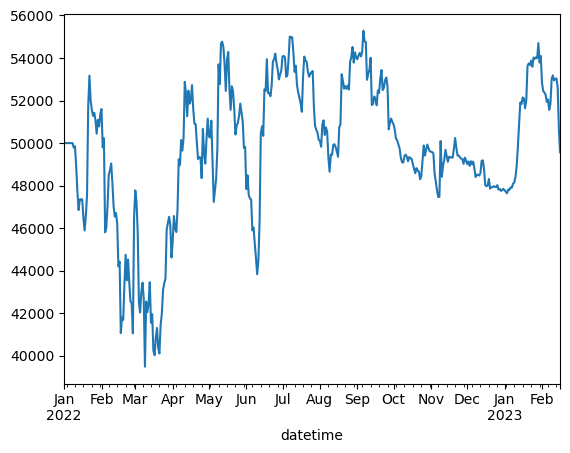

In [12]:
equities =portfolio.equity_handler.get_equities()
equity_portfolio = equities['equity_portfolio']['equity']
metrics =return_series.from_nav(equity_portfolio)
equity_portfolio.plot()

In [13]:
metrics.summary()

Performance number
Return                                       -0.8678
# Events                                         412
# Events per year                                365
Annua Return                                -0.77215
Annua Volatility                             38.6183
Annua Sharpe Ratio (r_f = 0)              -0.0199944
Max Drawdown                                 25.7409
Max % return                                  13.331
Min % return                                 -8.8056
MTD                                         -8.36704
YTD                                            3.581
Current Nav                                  49566.1
Max Nav                                      55283.6
Current Drawdown                             10.3421
Calmar Ratio (3Y)                          -0.029997
# Positive Events                                195
# Negative Events                                217
Value at Risk (alpha = 95)                   3.05936
Conditional Value at Risk (